In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import skimage.io as io
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm
import os.path as osp

In [3]:
class MNIST_DataLoader(Dataset):
    def __init__(self, data_path, normalize=True, to_torch=True):
        self.data_path = data_path
        self.normalize = normalize
        self.to_torch = to_torch
        
        self.images_names2idx = {}
        self.images_names = os.listdir(self.data_path)
        for i, image_name in enumerate(self.images_names):
            self.images_names2idx[image_name] = i
    
    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, idx):
        image_name = osp.join(self.data_path, self.images_names[idx])
        image = io.imread(image_name) / 255.
        if self.normalize:
            image = image
        if self.to_torch:
            image = torch.Tensor(image).unsqueeze(0)
        return image, int(self.images_names[idx].split('_')[0])
    
    def get_by_name(self, name):
        return self[self.images_names2idx[name]]

In [444]:
train_dataset = MNIST_DataLoader('./datasets/MNIST/images/train/')
test_dataset = MNIST_DataLoader('./datasets/MNIST/images/test/')

In [445]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 500 


In [446]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [448]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3136, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
#         print(x.shape)
        x = self.maxpool2(self.relu2(self.conv2(x)))
#         print(x.shape)
        x = self.flatten(x)
        x = self.fc2(self.fc1(x))
        return x


In [410]:
net2 = Net()

In [411]:
net2(torch.randn(3, 1, 28, 28))

tensor([[-0.0223,  0.1205,  0.0665, -0.0123,  0.0003, -0.0732,  0.1957, -0.0004,
          0.0241, -0.0055],
        [-0.0356,  0.1459,  0.0893, -0.0385,  0.0395, -0.0864,  0.2554, -0.0138,
          0.1601, -0.0560],
        [-0.1390,  0.1533,  0.0500, -0.0066,  0.0194, -0.1405,  0.1783, -0.0516,
          0.0767, -0.0368]], grad_fn=<AddmmBackward>)

In [534]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_dataloader)):
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = network(data)
#         print(output)
        loss = F.mse_loss(output, F.one_hot(target, 10).type(torch.float32))
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_dataloader.dataset)))
#           torch.save(network.state_dict(), '/results/model.pth')
#            torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [535]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_dataloader):
            data = data.cuda()
            target = target.cuda()
            output = network(data)
            test_loss += F.mse_loss(output, F.one_hot(target, 10).type(torch.float32), size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_dataloader.dataset), 100. * correct / len(test_dataloader.dataset)))

In [536]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_dataloader.dataset) for i in range(n_epochs + 1)]
network = Net().cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

# test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

  1%|          | 7/938 [00:00<00:32, 28.60it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.107733


 54%|█████▍    | 507/938 [00:13<00:10, 39.58it/s]

Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.064692


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  1%|          | 5/938 [00:00<00:18, 49.68it/s]


Test set: Avg. loss: 0.4915, Accuracy: 8394/10000 (84%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.051276


 54%|█████▍    | 509/938 [00:09<00:08, 50.91it/s]

Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.043644


  1%|          | 5/938 [00:00<00:19, 47.49it/s]


Test set: Avg. loss: 0.3811, Accuracy: 8948/10000 (89%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.038542


 54%|█████▍    | 509/938 [00:09<00:08, 52.28it/s]

Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.038825


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Test set: Avg. loss: 0.3300, Accuracy: 9164/10000 (92%)



In [537]:
net = network.cpu()

In [538]:
net(torch.ones(1, 1, 28, 28))

tensor([[ 0.2917,  0.7060,  0.2334, -0.0324,  0.3311,  0.0985,  0.2077,  0.1966,
         -0.1793, -0.1354]], grad_fn=<AddmmBackward>)

In [539]:
example = test_dataset[0][0].unsqueeze(0)

In [540]:
traced_script_module = torch.jit.trace(net, example)

In [541]:
traced_script_module.fc1.weight.shape

torch.Size([100, 3136])

In [542]:
traced_script_module.save("./models/model.pt")

In [295]:
arr = None
for module in net.named_children():
    print(module[0])
    break
    print(type(module))
    have_params = False
    for par in module.parameters():
        have_params = True
    #     print(module)
        arr = par.detach().numpy()
        print(arr)
        print("-"*24)
    #     break
    if not have_params:
        print("No params")
    print("-"*24)

conv1


In [272]:
arr.shape

(32, 1, 3, 3)

In [273]:
print(arr[0][0][0][0])
print(arr[15][0][1][2])
print(arr[31][0][2][2])

-0.15601239
0.29393446
0.12855923


In [296]:
l = [0.123, 0.41, 0.123, 0.4]

In [312]:
from array import array
a = array('f', l)

In [313]:
a

array('f', [0.12300000339746475, 0.4099999964237213, 0.12300000339746475, 0.4000000059604645])

In [315]:
with open("./bin.arr", 'wb') as f:
    a.tofile(f)

In [378]:
arr = torch.zeros((8, 8))
for i in range(8):
    for j in range(8):
        arr[i][j] = (i * 8 + j) ** 2

In [379]:
print(arr)

tensor([[0.0000e+00, 1.0000e+00, 4.0000e+00, 9.0000e+00, 1.6000e+01, 2.5000e+01,
         3.6000e+01, 4.9000e+01],
        [6.4000e+01, 8.1000e+01, 1.0000e+02, 1.2100e+02, 1.4400e+02, 1.6900e+02,
         1.9600e+02, 2.2500e+02],
        [2.5600e+02, 2.8900e+02, 3.2400e+02, 3.6100e+02, 4.0000e+02, 4.4100e+02,
         4.8400e+02, 5.2900e+02],
        [5.7600e+02, 6.2500e+02, 6.7600e+02, 7.2900e+02, 7.8400e+02, 8.4100e+02,
         9.0000e+02, 9.6100e+02],
        [1.0240e+03, 1.0890e+03, 1.1560e+03, 1.2250e+03, 1.2960e+03, 1.3690e+03,
         1.4440e+03, 1.5210e+03],
        [1.6000e+03, 1.6810e+03, 1.7640e+03, 1.8490e+03, 1.9360e+03, 2.0250e+03,
         2.1160e+03, 2.2090e+03],
        [2.3040e+03, 2.4010e+03, 2.5000e+03, 2.6010e+03, 2.7040e+03, 2.8090e+03,
         2.9160e+03, 3.0250e+03],
        [3.1360e+03, 3.2490e+03, 3.3640e+03, 3.4810e+03, 3.6000e+03, 3.7210e+03,
         3.8440e+03, 3.9690e+03]])


In [399]:
net.conv1(arr.unsqueeze(0).unsqueeze(0))

tensor([[[[ 6.1861e+00,  2.1963e+01,  2.8205e+01,  ...,  5.4465e+01,
            6.5731e+01,  5.9606e+01],
          [ 3.8645e+01,  1.0575e+02,  1.2029e+02,  ...,  1.6838e+02,
            1.8590e+02,  1.8016e+02],
          [ 7.9508e+01,  2.4294e+02,  2.6344e+02,  ...,  3.2941e+02,
            3.5289e+02,  3.7464e+02],
          ...,
          [ 1.0120e+02,  9.4058e+02,  9.7896e+02,  ...,  1.0986e+03,
            1.1399e+03,  1.4055e+03],
          [ 7.4792e+01,  1.2685e+03,  1.3128e+03,  ...,  1.4503e+03,
            1.4976e+03,  1.8983e+03],
          [-3.1255e+02,  3.9387e+02,  4.0512e+02,  ...,  4.3973e+02,
            4.5155e+02,  1.3463e+03]],

         [[ 3.1612e+01,  4.8618e+01,  6.1282e+01,  ...,  1.1368e+02,
            1.3596e+02,  9.6697e+01],
          [ 1.4268e+02,  2.1608e+02,  2.4639e+02,  ...,  3.4580e+02,
            3.8178e+02,  2.7049e+02],
          [ 3.2970e+02,  4.9823e+02,  5.3988e+02,  ...,  6.7335e+02,
            7.2068e+02,  5.2001e+02],
          ...,
     

In [566]:
net.conv1(torch.ones(1, 1, 28, 28))[0][-2]

tensor([[-0.9449, -0.9542, -0.9542, -0.9542, -0.9542, -0.9542, -0.9542, -0.9542,
         -0.9542, -0.9542, -0.9542, -0.9542, -0.9542, -0.9542, -0.9542, -0.9542,
         -0.9542, -0.9542, -0.9542, -0.9542, -0.9542, -0.9542, -0.9542, -0.9542,
         -0.9542, -0.9542, -0.9542, -0.4869],
        [-0.9610, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248,
         -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248,
         -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248,
         -1.2248, -1.2248, -1.2248, -0.4592],
        [-0.9610, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248,
         -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248,
         -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248,
         -1.2248, -1.2248, -1.2248, -0.4592],
        [-0.9610, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248, -1.2248,
         -1.2248, -1.2248, -1.2248, -1.2248, -1.2248

In [548]:
image = test_dataset.get_by_name('0_0.jpg')

In [563]:
net.maxpool2(net.relu2(net.conv2(net.maxpool1(net.relu1(net.conv1(image[0].unsqueeze(0)))))))[0][-1]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0011, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<SelectBackward>)

6 tensor([[6]])


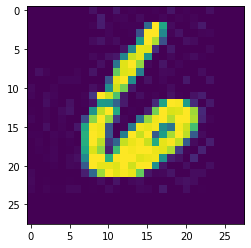

4 tensor([[4]])


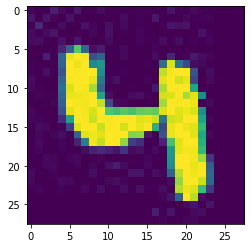

7 tensor([[7]])


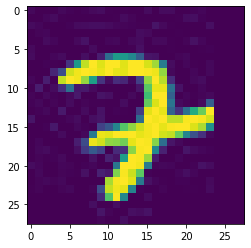

7 tensor([[7]])


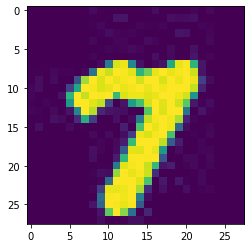

1 tensor([[1]])


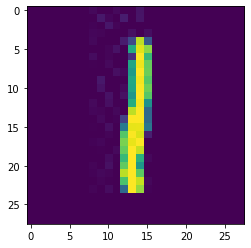

5 tensor([[5]])


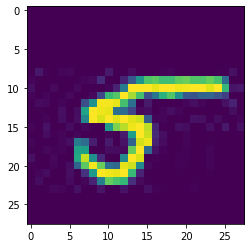

8 tensor([[8]])


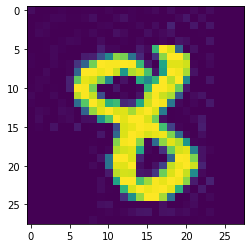

5 tensor([[5]])


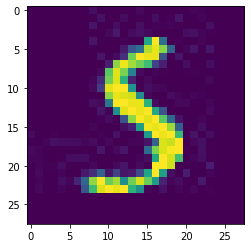

3 tensor([[3]])


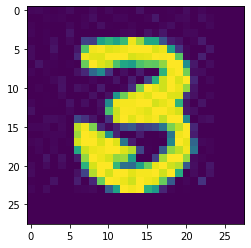

3 tensor([[3]])


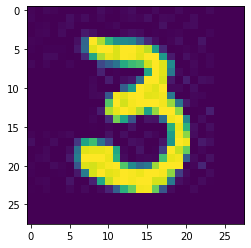

1 tensor([[1]])


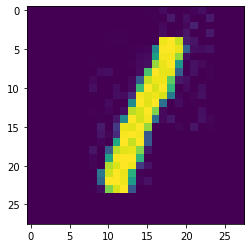

6 tensor([[6]])


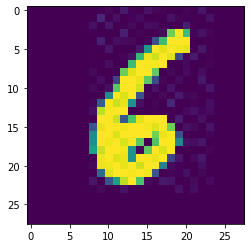

6 tensor([[6]])


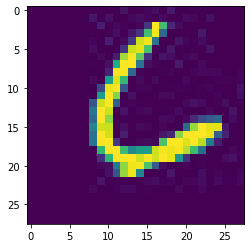

2 tensor([[2]])


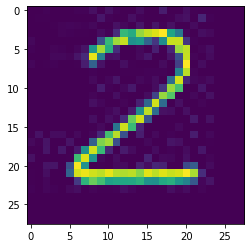

7 tensor([[9]])


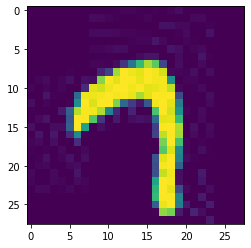

9 tensor([[9]])


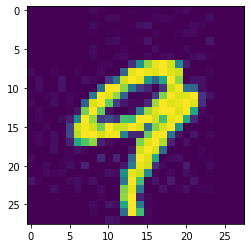

2 tensor([[2]])


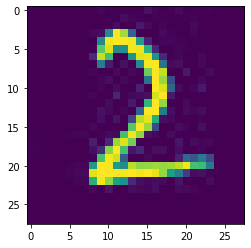

4 tensor([[4]])


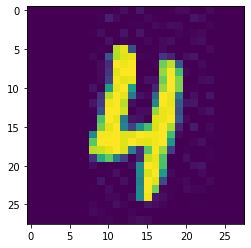

0 tensor([[0]])


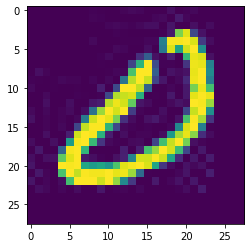

9 tensor([[9]])


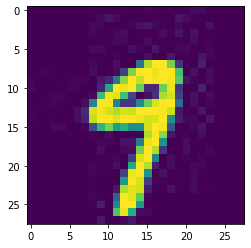

0 tensor([[0]])


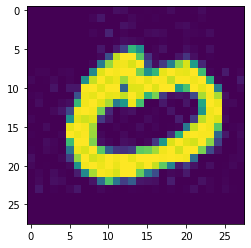

4 tensor([[4]])


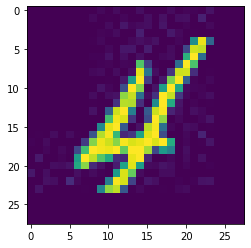

5 tensor([[4]])


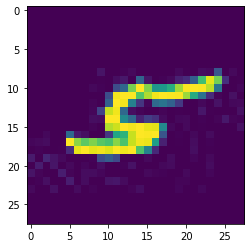

4 tensor([[4]])


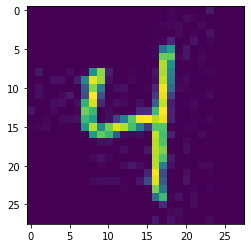

1 tensor([[1]])


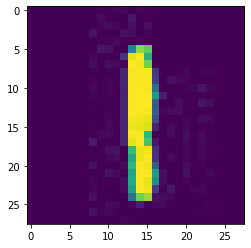

0 tensor([[6]])


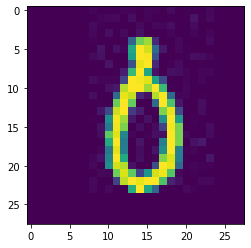

5 tensor([[5]])


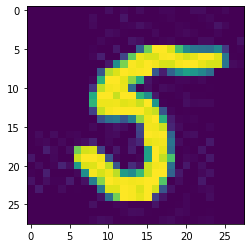

7 tensor([[1]])


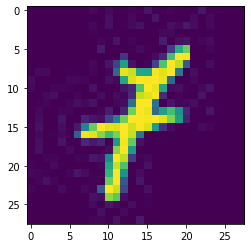

0 tensor([[0]])


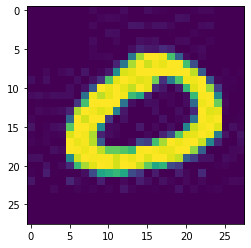

2 tensor([[2]])


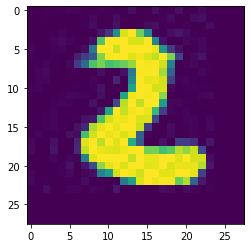

1 tensor([[1]])


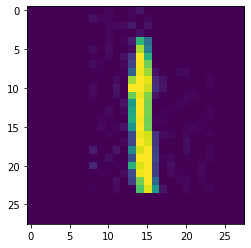

1 tensor([[1]])


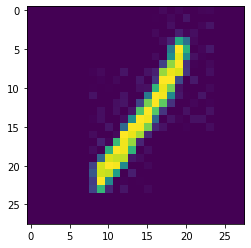

2 tensor([[2]])


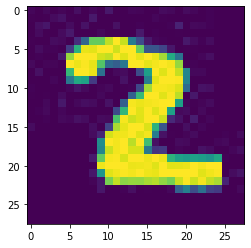

9 tensor([[9]])


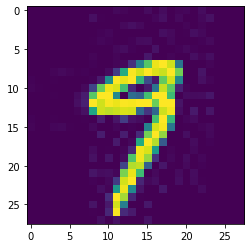

7 tensor([[7]])


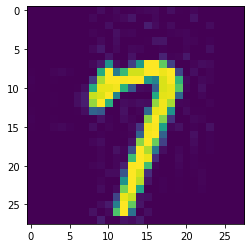

7 tensor([[7]])


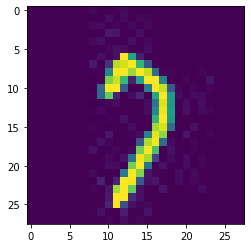

5 tensor([[5]])


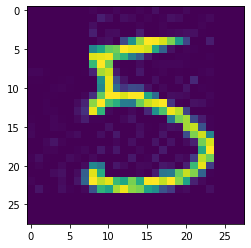

7 tensor([[7]])


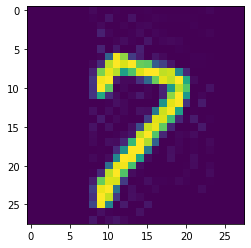

8 tensor([[8]])


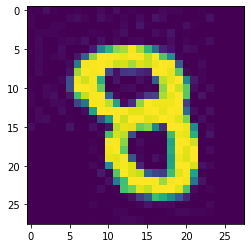

1 tensor([[1]])


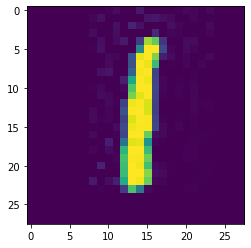

6 tensor([[6]])


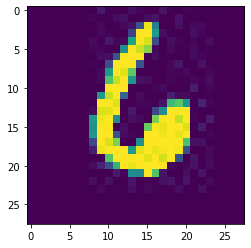

0 tensor([[0]])


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [546]:
for image, label in test_dataset:
    print(label, net(image.unsqueeze(0)).max(1, keepdim=True)[1])
    plt.imshow(image.numpy()[0])
    plt.show()

In [551]:
net(image[0].unsqueeze(0))

tensor([[ 0.7774, -0.0986,  0.0191,  0.0460, -0.0580, -0.0434,  0.1922,  0.1193,
         -0.0409,  0.1001]], grad_fn=<AddmmBackward>)

In [501]:
net.maxpool2(net.relu2(net.conv2(net.maxpool1(net.relu1(net.conv1(torch.ones(1, 1, 28, 28)))))))

tensor([[[[0.2319, 0.2079, 0.2079,  ..., 0.2079, 0.2079, 0.2012],
          [0.0149, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0016],
          [0.0149, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0016],
          ...,
          [0.0149, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0016],
          [0.0149, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0016],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0820, 0.0622, 0.0622,  ..., 0.0622, 0.0622, 0.0994],
          [0.0378, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0314],
          [0.0378, 0.0000, 0.0000,  ..., 0

net.flatten(net.maxpool2(net.relu2(net.conv2(net.maxpool1(net.relu1(net.conv1(torch.ones(1, 1, 28, 28))))))))

# 256 model


In [5]:
train_dataset = MNIST_DataLoader('./datasets/MNIST/images/train/')
test_dataset = MNIST_DataLoader('./datasets/MNIST/images/test/')

In [6]:
import cv2

In [7]:
io.imsave?

In [577]:
train_path = './datasets/MNIST/images/test/'
train_path_256 = './datasets/MNIST/images/test_256/'
os.makedirs(train_path_256, exist_ok=True)
for image_name in os.listdir(train_path):
    image = io.imread(osp.join(train_path, image_name))
    res_image = cv2.resize(image, (256, 256))
    io.imsave(osp.join(train_path_256, image_name), res_image)

#     plt.show()
#     print(image_name)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(2)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2048, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
#         print(x.shape)
        x = self.maxpool2(self.relu2(self.conv2(x)))
#         print(x.shape)
        x = self.maxpool3(self.relu3(self.conv3(x)))
#         print(x.shape)
        x = self.maxpool4(self.relu4(self.conv4(x)))
#         print(x.shape)
        x = self.maxpool5(self.relu5(self.conv5(x)))
#         print(x.shape)
        x = self.flatten(x)
        x = self.fc2(self.fc1(x))
        return x


In [9]:
32 * 8 * 8

2048

In [10]:
net = Net()

In [11]:
net(torch.rand(1, 1, 256, 256))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[ 0.0901, -0.0222, -0.0365,  0.0570,  0.0817, -0.0182,  0.0327, -0.0880,
          0.0146,  0.0803]], grad_fn=<AddmmBackward>)

In [12]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_dataloader)):
        data = data.cuda()
        target = target.cuda()
        optimizer.zero_grad()
        output = network(data)
#         print(output)
        loss = F.mse_loss(output, F.one_hot(target, 10).type(torch.float32))
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_dataloader.dataset)))
#           torch.save(network.state_dict(), '/results/model.pth')
#            torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [13]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_dataloader):
            data = data.cuda()
            target = target.cuda()
            output = network(data)
            test_loss += F.mse_loss(output, F.one_hot(target, 10).type(torch.float32), size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_dataloader.dataset), 100. * correct / len(test_dataloader.dataset)))

In [14]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 500 


In [15]:
train_dataset = MNIST_DataLoader('./datasets/MNIST/images/train_256/')
test_dataset = MNIST_DataLoader('./datasets/MNIST/images/test_256/')

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [17]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_dataloader.dataset) for i in range(n_epochs + 1)]
network = Net().cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

# test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

  1%|          | 5/938 [00:00<00:51, 18.07it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.102600


 54%|█████▍    | 506/938 [00:20<00:17, 24.15it/s]

Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.090080


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 3/938 [00:00<00:42, 21.92it/s]


Test set: Avg. loss: 0.8997, Accuracy: 1135/10000 (11%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.089608


 54%|█████▎    | 504/938 [00:19<00:18, 23.38it/s]

Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.090058


  0%|          | 3/938 [00:00<00:42, 22.06it/s]


Test set: Avg. loss: 0.8997, Accuracy: 1135/10000 (11%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.089945


 54%|█████▎    | 504/938 [00:19<00:17, 24.81it/s]

Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.089935


  0%|          | 3/938 [00:00<00:42, 21.90it/s]


Test set: Avg. loss: 0.8995, Accuracy: 1135/10000 (11%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.090107


 54%|█████▎    | 504/938 [00:20<00:17, 24.51it/s]

Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.089861


  0%|          | 1/938 [00:00<01:48,  8.61it/s]


Test set: Avg. loss: 0.8994, Accuracy: 1135/10000 (11%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.090147


 54%|█████▍    | 505/938 [00:32<00:19, 22.79it/s]

Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.090081


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Test set: Avg. loss: 0.8992, Accuracy: 1135/10000 (11%)

